# Creating Art with Deep Convolutional Generative Adversarial Networks

## 1. Load Data

In [1]:
import tensorflow as tf
import os
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

import pandas as pd
from tensorflow.keras.preprocessing.image import load_img
import pathlib
import glob
from PIL import Image
from skimage.transform import resize
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
from IPython import display

In [2]:
BASE_PATH = '/notebooks/storage/abstract_art_generator/'
img_size_target = 59
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [3]:
data_dir = pathlib.Path(BASE_PATH)
images = list(data_dir.glob('art_dataset/*.jpg'))
images[0].name

'Marc_Chagall_129.jpg'

In [4]:
train_images_org = ([(np.array(load_img(BASE_PATH + 'art_dataset/{}'.format(file.name), color_mode='rgb')) - 128 / 128 ) for file in images])
train_images = [resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True) for img in train_images_org]
train_images = np.stack(train_images, axis=0)

train_images.shape

(954, 59, 59, 3)

In [5]:
train_images = np.asarray(train_images).astype(np.float32)

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 2. Models

### 2.1 Generator

In [7]:
# input vector
nz = 100

# size of image
ngf = 64
 
# number of channels
nc = 3

In [8]:
def make_generator_model():

    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(ngf, (4, 4), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)

    model.add(layers.Conv2DTranspose(nc, (4, 4), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    print(model.output_shape)


    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), output_padding=1, use_bias=False, activation='tanh'))
    print(model.output_shape)
    
    return model

(None, 14, 14, 64)
(None, 28, 28, 3)
(None, 59, 59, 3)
(1, 59, 59, 3)


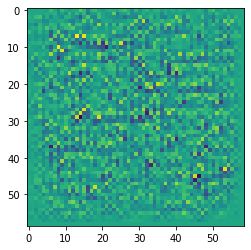

In [9]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)

plt.imshow(generated_image[0, :, :, 0] )

### 2.2 Discriminator

In [10]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[img_size_target, img_size_target, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [11]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

(None, 28800)
(None, 1)
tf.Tensor([[-0.00187514]], shape=(1, 1), dtype=float32)


### 2.3 Loss and Optimizer

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 3. Training

In [17]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [18]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
        
      real_output = discriminator(images, training=True)

      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [21]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 1] * 127.5 + 127.5)
      plt.axis('off')

#   plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [23]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

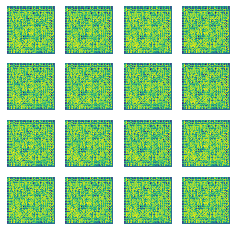

In [22]:
train(train_dataset, EPOCHS)